In [ ]:
!pip install imblearn

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 950)
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from IPython.display import Image  

import pydotplus
from imblearn.over_sampling import SMOTE

In [25]:
df = pd.read_csv('whiskey_database.csv')
df.rename(columns = {'#': 'reviews', 'Super Cluster': 'supercluster', 'Meta Critic':'metascore'}, inplace = True)

In [26]:
df.shape

(1611, 10)

In [27]:
df.head()

,Whisky,metascore,STDEV,reviews,Cost,Class,supercluster,Cluster,Country,Type
0,Ledaig 42yo Dusgadh,9.46,0.24,3,$$$$$+,SingleMalt-like,ABC,C,Scotland,Malt
1,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.38,0.20,4,$$$$$+,SingleMalt-like,ABC,C,Scotland,Malt
2,Glenfarclas 40yo,9.27,0.26,15,$$$$$+,SingleMalt-like,ABC,A,Scotland,Malt
3,Glengoyne 25yo,9.20,0.23,14,$$$$$+,SingleMalt-like,ABC,A,Scotland,Malt
4,Amrut Spectrum (Batch 1),9.18,0.25,10,$$$$$,SingleMalt-like,ABC,C,India,Malt


In [ ]:
df.Country.value_counts()

In [ ]:
sns_plot = sns.catplot(x="Country", kind="count", palette="RdBu_r", data=df, height=8.27, aspect=15/10);
sns_plot.savefig("output.png")

In [ ]:
#irish whiskey popularity declined until there were only 3 distilleries left by 1990.  More are coming back,
#but many have not been operating long enough to produce a saleable product.

In [ ]:
sns.catplot(x="Cluster", kind="count", palette="Set1", data=df, height=8.27, aspect=15/8.27);

In [ ]:
sns.catplot(x="Type", kind="count", palette="ch:.25", data=df, height=8.27, aspect=15/8.27);

In [ ]:
sns.catplot(x="Class", kind="count", palette="ch:.25", data=df, height=8.27, aspect=15/8.27);

In [ ]:
sns.catplot(x="supercluster", kind="count", palette="ch:3,.5,dark=.3", data=df, height=8.27, aspect=15/8.27);

#### Reference
Scotland: 1  
USA : 2  
Canada: 3  
Ireland: 4  
Japan: 5  
Sweden: 6  
India: 7  
Taiwan: 8  
Wales: 9  
Swizerland: 10  
Finland: 11  
Tasmania: 12  
South Africa: 13  
Netherlands: 14  
England: 15  
Belgium: 16  
France: 17  
Ireland: 18  

In [28]:
df['Country'] = df['Country'].replace({'Sweden': 'rest_of_world', 'India': 'rest_of_world', 'Taiwan': 'rest_of_world', 'Wales': 'rest_of_world', 'Switzerland': 'rest_of_world', 'Finland': 'rest_of_world', 'Tasmania': 'rest_of_world', 'South Africa': 'rest_of_world', 'Netherlands': 'rest_of_world', 'England': 'rest_of_world', 'Belgium': 'rest_of_world', 'France': 'rest_of_world', 'Irish': 'rest_of_world'})




In [29]:
df['Country'] = df['Country'].map({'Scotland': 1, 'USA': 2, 'Canada': 3, 'Ireland': 4, 'Japan': 5, 'rest_of_world': 6})


In [30]:
#RO will be B
#R1 will be A
#R2 will be E
#R3 will be C
#R4 will be F

In [31]:
df['Cluster'] = df['Cluster'].replace({'R2': 'E', 'R1': 'A', 'R4': 'F', 'R3': 'C', 'R0': 'B'})
df.dropna(subset=['Cluster'], how='any', inplace = True, axis = 0)
df.isna().sum()

Whisky            0
metascore         0
STDEV             0
reviews           0
Cost              1
Class             0
supercluster    254
Cluster           0
Country           0
Type              0
dtype: int64

In [32]:
target = df.Country

In [33]:
df.shape

(1344, 10)

In [34]:
dfDummies = pd.get_dummies(df.Cluster)
feature_cluster = dfDummies
df = pd.concat([df, dfDummies], axis =1 )

In [35]:
dfDummies = pd.get_dummies(df.Class)
df = pd.concat([df, dfDummies], axis =1 )

In [36]:
dfDummies = pd.get_dummies(df.Type)
df = pd.concat([df, dfDummies], axis =1 )

In [37]:
df = df.drop(['metascore', 'STDEV', 'reviews', 'Country'], axis = 1)
df.drop(['Whisky', 'Cost', 'supercluster'], axis = 1, inplace = True)
df.drop(['Class', 'Cluster', 'Type'], axis =1, inplace = True)

In [ ]:
df.head(10)

### Setting up Data for Models

In [38]:
def plot_feature_importances(model):
    n_features = x_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), x_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [39]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='weighted')))

In [40]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
    # Compute confusion matrix
    cmat = pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)
    print(cmat)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix

plt.show()

In [41]:
#variables include flavor, type, class
x = df
y = target

In [ ]:
#just flavor as variable
x = feature_cluster
y = target

In [ ]:
x.shape

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .2, random_state = 42)

In [43]:
#SMOOOOOTTTEEEDDD!!!!
print(y.value_counts()) #Previous original class distribution
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_sample(x_train, y_train) 
print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution

1    814
2    263
6    137
5     58
4     43
3     29
Name: Country, dtype: int64
5    650
3    650
1    650
6    650
4    650
2    650
dtype: int64


In [44]:
print(x_train_resampled.shape)
print(x_test.shape)

print(y_train_resampled.shape)
print(y_test.shape)

(3900, 19)
(269, 19)
(3900,)
(269,)


### Running Models

#### KNN

In [45]:
#K Nearest Neighbor test
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
knnfit = knn.fit(x_train_resampled, y_train_resampled)
test_preds = knn.predict(x_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='macro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='micro')))
    
print_metrics(y_test, test_preds)

Precision Score: 0.38625841750841755
Recall Score: 0.7211895910780669
Accuracy Score: 0.7211895910780669
F1 Score: 0.7211895910780669


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
from sklearn.metrics import precision_recall_fscore_support as score
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
precision, recall, fscore, support = score(y_test, test_preds,)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.8 1.  0.  0.5 0.  0. ]
recall: [0.8 0.9 0.2 0.3 0.  0. ]
fscore: [0.8 1.  0.  0.4 0.  0. ]
support: [164  56   5  10   9  25]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_preds, target_names=labels))


               precision    recall  f1-score   support

     Scotland       0.79      0.85      0.82       164
          USA       1.00      0.91      0.95        56
       Canada       0.03      0.20      0.05         5
      Ireland       0.50      0.30      0.37        10
        Japan       0.00      0.00      0.00         9
Rest_of_World       0.00      0.00      0.00        25

     accuracy                           0.72       269
    macro avg       0.39      0.38      0.37       269
 weighted avg       0.71      0.72      0.71       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
#knn with weight distance and ball_tree algo
knn = KNeighborsClassifier(n_neighbors=5, weights = 'distance', algorithm='ball_tree')
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
knnfit = knn.fit(x_train_resampled, y_train_resampled)
test_preds = knn.predict(x_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='micro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='micro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='micro')))
    
print_metrics(y_test, test_preds)

Precision Score: 0.7211895910780669
Recall Score: 0.7211895910780669
Accuracy Score: 0.7211895910780669
F1 Score: 0.7211895910780669


In [49]:
#KNN with Euclidian distance
knn = KNeighborsClassifier(n_neighbors=3, metric = 'euclidean')
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
knnfit = knn.fit(x_train_resampled, y_train_resampled)
test_preds = knn.predict(x_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='micro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='micro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='micro')))
    
print_metrics(y_test, test_preds)

Precision Score: 0.654275092936803
Recall Score: 0.654275092936803
Accuracy Score: 0.654275092936803
F1 Score: 0.654275092936803


In [50]:
#Finding best KNN neighbor via F1 score
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds, average = 'micro')
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

find_best_k(x_train_resampled, y_train_resampled, x_test, y_test)

Best Value for k: 5
F1-Score: 0.7211895910780669


In [51]:
#rerun KNN with best
from sklearn.neighbors import KNeighborsClassifier
def updateKNN(x, x_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=x)

    knn.fit(x_train, y_train)
    test_preds = knn.predict(x_test)    
    print_metrics(y_test, test_preds)



In [53]:
updateKNN(5, x_train_resampled, y_train_resampled)

Precision Score: 0.7211895910780669
Recall Score: 0.7211895910780669
Accuracy Score: 0.7211895910780669
F1 Score: 0.7211895910780669


In [54]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'p' : [1,2,3]
}

gs = GridSearchCV(
    knn,
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1)

gs_results = gs.fit(x_train_resampled, y_train_resampled)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    4.3s finished


In [55]:
gs_results.best_score_
gs_results.best_estimator_
gs_results.best_params_

{'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

In [56]:
knn = KNeighborsClassifier(n_neighbors=11, weights = 'distance', p = 1)
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
knnfit = knn.fit(x_train_resampled, y_train_resampled)
test_preds = knn.predict(x_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='micro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='micro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='micro')))
    
print_metrics(y_test, test_preds)

Precision Score: 0.7211895910780669
Recall Score: 0.7211895910780669
Accuracy Score: 0.7211895910780669
F1 Score: 0.7211895910780669


In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_preds, target_names=labels))

               precision    recall  f1-score   support

     Scotland       0.79      0.85      0.82       164
          USA       1.00      0.91      0.95        56
       Canada       0.03      0.20      0.05         5
      Ireland       0.50      0.30      0.37        10
        Japan       0.00      0.00      0.00         9
Rest_of_World       0.00      0.00      0.00        25

     accuracy                           0.72       269
    macro avg       0.39      0.38      0.37       269
 weighted avg       0.71      0.72      0.71       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
from sklearn.metrics import confusion_matrix 
results = pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)
print(results)

Predicted    1   2   3  4  All
True                          
1          139   0  24  1  164
2            3  51   2  0   56
3            4   0   1  0    5
4            4   0   3  3   10
5            5   0   2  2    9
6           21   0   4  0   25
All        176  51  36  6  269


Predicted    1   2   3  4  All
True                          
1          139   0  24  1  164
2            3  51   2  0   56
3            4   0   1  0    5
4            4   0   3  3   10
5            5   0   2  2    9
6           21   0   4  0   25
All        176  51  36  6  269


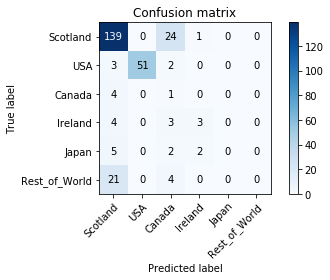

In [59]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cmat = pd.crosstab(y_test, test_preds, rownames=['True'], colnames=['Predicted'], margins=True)
    print(cmat)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, test_preds, classes=labels,
                      title='Confusion matrix')


plt.show()

In [ ]:
df.corr()


In [60]:
#test knn with RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearn import neighbors
rmse_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 2.4983265774778807
RMSE value for k=  2 is: 1.8079234941210305
RMSE value for k=  3 is: 1.6979711877654518
RMSE value for k=  4 is: 1.6395722082367414
RMSE value for k=  5 is: 1.6254481795451423
RMSE value for k=  6 is: 1.6140069973084363
RMSE value for k=  7 is: 1.5992800519676982
RMSE value for k=  8 is: 1.5665977864580671
RMSE value for k=  9 is: 1.5986966328420984
RMSE value for k=  10 is: 1.6373997883579008
RMSE value for k=  11 is: 1.60680754011867
RMSE value for k=  12 is: 1.62350398203325
RMSE value for k=  13 is: 1.618377607746864
RMSE value for k=  14 is: 1.604412917156881
RMSE value for k=  15 is: 1.6268655291123868
RMSE value for k=  16 is: 1.61355258000434
RMSE value for k=  17 is: 1.6205776289348255
RMSE value for k=  18 is: 1.6189826082607122
RMSE value for k=  19 is: 1.6114856417274412
RMSE value for k=  20 is: 1.6076172073916908


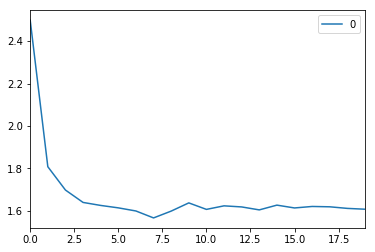

In [61]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

#### Decision Trees

In [62]:
#Decision Tree
clf= DecisionTreeClassifier(criterion='entropy')
clf.fit(x_train_resampled,y_train_resampled) 
y_pred = clf.predict(x_test)
print(y_pred)

[6 1 5 6 6 3 5 1 2 6 6 1 5 2 4 6 3 4 6 6 1 1 6 4 1 2 6 6 5 5 5 2 1 6 6 2 6
 5 5 2 6 6 6 6 6 1 5 6 6 2 6 6 2 5 3 6 2 3 5 2 6 5 6 6 3 5 1 6 5 6 6 2 3 6
 6 6 2 6 2 5 3 3 6 2 6 5 6 1 4 3 6 1 5 6 6 6 6 5 6 6 5 2 3 5 5 2 6 3 6 3 1
 6 5 6 5 6 5 6 1 3 2 3 3 6 5 6 6 1 4 2 6 5 3 5 3 6 1 1 5 2 1 5 6 1 3 3 6 5
 6 2 5 2 5 6 2 6 2 5 2 5 3 1 5 2 5 5 6 6 2 6 2 2 6 3 1 1 5 2 3 2 2 5 1 1 5
 6 5 3 2 6 6 1 1 6 6 6 2 5 6 5 1 2 3 5 6 6 6 6 3 3 5 5 1 2 6 2 1 2 6 6 1 5
 3 2 6 6 4 6 3 2 5 6 2 5 3 2 3 3 6 5 6 3 6 1 2 2 6 6 5 2 3 6 2 3 6 6 2 2 6
 2 2 3 2 6 3 1 1 2 6]


In [63]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.externals.six import StringIO  
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))

# # Check the AUC for predictions
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is :36.059479553903344

Confusion Matrix
----------------


/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Predicted,1,2,3,4,5,6,All
True,,,,,,,
1,28,0,24,1,38,73,164
2,0,51,2,0,1,2,56
3,1,0,1,0,3,0,5
4,1,0,3,3,1,2,10
5,1,0,2,2,1,3,9
6,1,0,4,0,7,13,25
All,32,51,36,6,51,93,269


[[28  0 24  1 38 73]
 [ 0 51  2  0  1  2]
 [ 1  0  1  0  3  0]
 [ 1  0  3  3  1  2]
 [ 1  0  2  2  1  3]
 [ 1  0  4  0  7 13]]


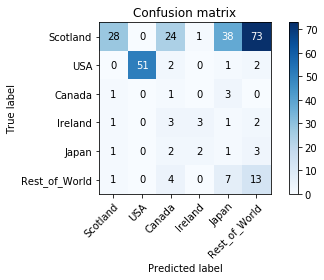

In [64]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels,
                      title='Confusion matrix')


plt.show()

#### Reference
Scotland: 1  
USA : 2  
Canada: 3  
Ireland: 4  
Japan: 5  
Sweden: 6  
India: 7  
Taiwan: 8  
Wales: 9  
Swizerland: 10  
Finland: 11  
Tasmania: 12  
South Africa: 13  
Netherlands: 14  
England: 15  
Belgium: 16  
France: 17  
Ireland: 18  

#### Regression Tree

In [65]:
#Regression Tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 10, max_depth=7, min_samples_leaf = 2)
regressor.fit(x_train_resampled, y_train_resampled)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=10, splitter='best')

In [66]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Make predictions and evaluate 
y_pred = regressor.predict(x_test)
print ('MSE score:', mse(y_test, y_pred))
print('R-sq score:',r2_score(y_test,y_pred))

MSE score: 5.027862091021895
R-sq score: -0.9616594349823437


In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [68]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5, max_leaf_nodes = 8) 
tree_clf.fit(x_train_resampled, y_train_resampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [69]:
tree_clf.feature_importances_

array([0. , 0.1, 0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0. , 0. , 0.7, 0. ,
       0. , 0. , 0.1, 0. , 0. , 0. ])

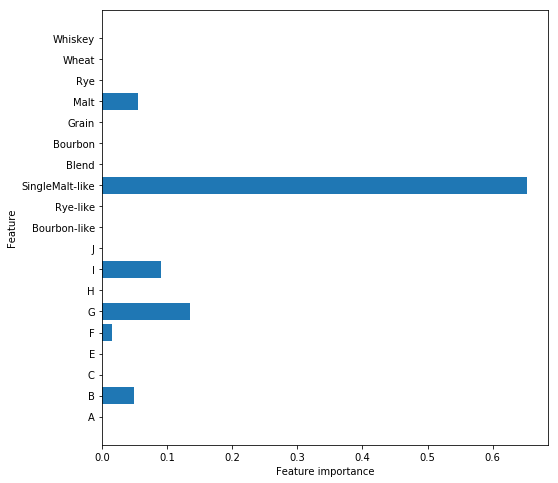

In [70]:
plot_feature_importances(tree_clf)

In [71]:
pred = tree_clf.predict(x_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


[[  0   0  18   1  25 120]
 [  0  51   1   0   1   3]
 [  0   0   1   0   3   1]
 [  0   0   3   3   0   4]
 [  0   0   2   2   1   4]
 [  0   0   2   0   5  18]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.03      0.11      0.05         9
           6       0.12      0.72      0.21        25

    accuracy                           0.28       269
   macro avg       0.28      0.37      0.27       269
weighted avg       0.24      0.28      0.23       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[  0   0  18   1  25 120]
 [  0  51   1   0   1   3]
 [  0   0   1   0   3   1]
 [  0   0   3   3   0   4]
 [  0   0   2   2   1   4]
 [  0   0   2   0   5  18]]


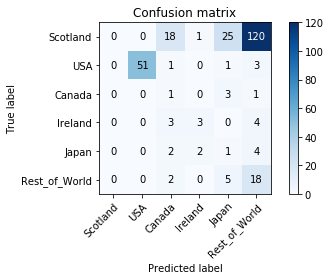

In [72]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']
 
plot_confusion_matrix(y_test, pred, classes=labels,
                      title='Confusion matrix')


plt.show()

#### Reference
Scotland: 1  
USA : 2  
Canada: 3  
Ireland: 4  
Japan: 5  
Sweden: 6  
India: 7  
Taiwan: 8  
Wales: 9  
Swizerland: 10  
Finland: 11  
Tasmania: 12  
South Africa: 13  
Netherlands: 14  
England: 15  
Belgium: 16  
France: 17  
Ireland: 18  

In [ ]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))


#### Bagged Tree

In [73]:
#bagged test
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)


In [74]:
clf = bagged_tree.fit(x_train_resampled, y_train_resampled)


In [75]:
bagged_tree.score(x_train_resampled, y_train_resampled)


0.5197435897435897

In [76]:
print("Testing Accuracy for Bagged Tree Test: {:.4}%".format(bagged_tree.score(x_test, y_test)*100))

Testing Accuracy for Bagged Tree Test: 49.81%


In [77]:
bagged_pred = bagged_tree.predict(x_test)

In [79]:

print(classification_report(y_test, bagged_pred))

              precision    recall  f1-score   support

           1       0.87      0.40      0.54       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.03      0.11      0.05         9
           6       0.17      0.52      0.26        25

    accuracy                           0.50       269
   macro avg       0.43      0.41      0.37       269
weighted avg       0.77      0.50      0.57       269



[[65  0 18  1 25 55]
 [ 1 51  1  0  1  2]
 [ 1  0  1  0  3  0]
 [ 2  0  3  3  0  2]
 [ 1  0  2  2  1  3]
 [ 5  0  2  0  5 13]]


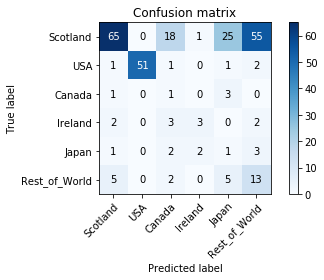

In [78]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, bagged_pred, classes=labels,
                      title='Confusion matrix')
plt.show()

#### Random Forest

In [80]:
#Random Forest
forest = RandomForestClassifier(n_estimators=100, max_depth= 5, max_leaf_nodes = 20)
forest.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [81]:
forest.score(x_train_resampled, y_train_resampled)

0.5435897435897435

In [85]:
RFpred = tree_clf.predict(x_test)
print(confusion_matrix(y_test, RFpred))
print(classification_report(y_test, RFpred))

[[  0   0  18   1  25 120]
 [  0  51   1   0   1   3]
 [  0   0   1   0   3   1]
 [  0   0   3   3   0   4]
 [  0   0   2   2   1   4]
 [  0   0   2   0   5  18]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.03      0.11      0.05         9
           6       0.12      0.72      0.21        25

    accuracy                           0.28       269
   macro avg       0.28      0.37      0.27       269
weighted avg       0.24      0.28      0.23       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
print("Testing Accuracy for Random Forest Test: {:.4}%".format(forest.score(x_test, y_test)*100))


Testing Accuracy for Random Forest Test: 34.2%


In [86]:
print(classification_report(y_test, RFpred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.03      0.11      0.05         9
           6       0.12      0.72      0.21        25

    accuracy                           0.28       269
   macro avg       0.28      0.37      0.27       269
weighted avg       0.24      0.28      0.23       269



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


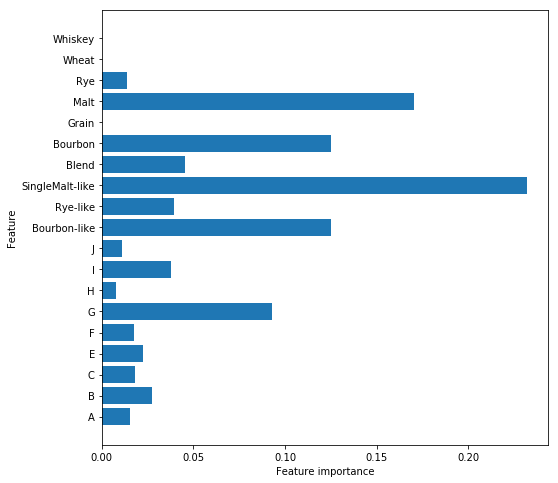

In [87]:
plot_feature_importances(forest)


In [ ]:
#closer look at random forest, smaller trees reduced n_estimators, max features, and max depth
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(x_train_resampled, y_train_resampled)

In [ ]:
rf_tree_1 = forest_2.estimators_[0]
plot_feature_importances(rf_tree_1)

In [ ]:
rf_tree_2 = forest_2.estimators_[1]
plot_feature_importances(rf_tree_2)

[[  0   0  18   1  25 120]
 [  0  51   1   0   1   3]
 [  0   0   1   0   3   1]
 [  0   0   3   3   0   4]
 [  0   0   2   2   1   4]
 [  0   0   2   0   5  18]]


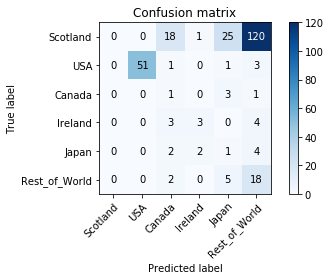

In [88]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, pred, classes=labels,
                      title='Confusion matrix')
plt.show()

#### AdaBoost and Gradient Boosting

In [89]:
#Adaboost
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [90]:
adaboost_clf = AdaBoostClassifier()
gbt_clf = GradientBoostingClassifier(learning_rate =.02)

In [91]:
adaboost_clf.fit(x_train_resampled, y_train_resampled)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [92]:
gbt_clf.fit(x_train_resampled, y_train_resampled)
#learning_rate = 2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.02, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [93]:
adaboost_train_preds = adaboost_clf.predict(x_train_resampled)
adaboost_test_preds = adaboost_clf.predict(x_test)
gbt_clf_train_preds = gbt_clf.predict(x_train_resampled)
gbt_clf_test_preds = gbt_clf.predict(x_test)

In [94]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average = 'micro')
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train_resampled, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train_resampled, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Training Metrics
Model: AdaBoost
Accuracy: 0.5007692307692307
F1-Score: 0.5007692307692307

Model: Gradient Boosted Trees
Accuracy: 0.5438461538461539
F1-Score: 0.5438461538461539

Testing Metrics
Model: AdaBoost
Accuracy: 0.34944237918215615
F1-Score: 0.34944237918215615

Model: Gradient Boosted Trees
Accuracy: 0.3420074349442379
F1-Score: 0.3420074349442379


In [95]:
print(classification_report(y_test, adaboost_test_preds))
print(classification_report(y_test, gbt_clf_test_preds))

              precision    recall  f1-score   support

           1       0.88      0.17      0.29       164
           2       1.00      0.86      0.92        56
           3       0.03      0.20      0.05         5
           4       0.50      0.30      0.37        10
           5       0.02      0.11      0.03         9
           6       0.14      0.52      0.22        25

    accuracy                           0.35       269
   macro avg       0.43      0.36      0.31       269
weighted avg       0.77      0.35      0.40       269

              precision    recall  f1-score   support

           1       0.91      0.13      0.22       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.02      0.11      0.03         9
           6       0.14      0.60      0.22        25

    accuracy                           0.34       269
   macro avg       0.43

In [96]:
adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
adaboost_confusion_matrix

array([[28,  0, 24,  1, 38, 73],
       [ 0, 48,  5,  0,  1,  2],
       [ 1,  0,  1,  0,  3,  0],
       [ 1,  0,  3,  3,  1,  2],
       [ 1,  0,  2,  2,  1,  3],
       [ 1,  0,  4,  0,  7, 13]])

[[28  0 24  1 38 73]
 [ 0 48  5  0  1  2]
 [ 1  0  1  0  3  0]
 [ 1  0  3  3  1  2]
 [ 1  0  2  2  1  3]
 [ 1  0  4  0  7 13]]


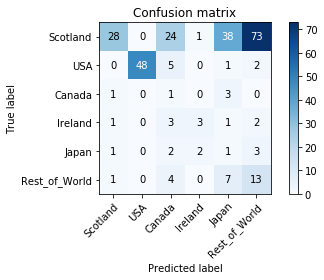

In [97]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, adaboost_test_preds, classes=labels,
                      title='Confusion matrix')
plt.show()

In [98]:
gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
gbt_confusion_matrix

array([[21,  0, 18,  1, 38, 86],
       [ 0, 51,  1,  0,  1,  3],
       [ 0,  0,  1,  0,  3,  1],
       [ 1,  0,  3,  3,  1,  2],
       [ 0,  0,  2,  2,  1,  4],
       [ 1,  0,  2,  0,  7, 15]])

[[21  0 18  1 38 86]
 [ 0 51  1  0  1  3]
 [ 0  0  1  0  3  1]
 [ 1  0  3  3  1  2]
 [ 0  0  2  2  1  4]
 [ 1  0  2  0  7 15]]


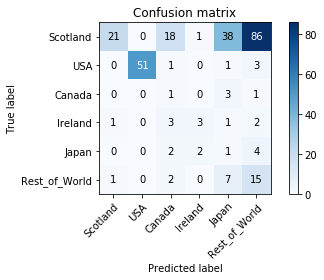

In [99]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, gbt_clf_test_preds, classes=labels,
                      title='Confusion matrix')
plt.show()

#### Reference
Scotland: 1  
USA : 2  
Canada: 3  
Ireland: 4  
Japan: 5  
Sweden: 6  
India: 7  
Taiwan: 8  
Wales: 9  
Swizerland: 10  
Finland: 11  
Tasmania: 12  
South Africa: 13  
Netherlands: 14  
England: 15  
Belgium: 16  
France: 17  
Ireland: 18  

In [100]:
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

           1       0.88      0.17      0.29       164
           2       1.00      0.86      0.92        56
           3       0.03      0.20      0.05         5
           4       0.50      0.30      0.37        10
           5       0.02      0.11      0.03         9
           6       0.14      0.52      0.22        25

    accuracy                           0.35       269
   macro avg       0.43      0.36      0.31       269
weighted avg       0.77      0.35      0.40       269



In [118]:
predictions = cross_val_predict(cvp, adaboost_test_preds, y_test, cv='prediction_proba')

NameError: name 'cross_val_predict' is not defined

In [101]:
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)

              precision    recall  f1-score   support

           1       0.91      0.13      0.22       164
           2       1.00      0.91      0.95        56
           3       0.04      0.20      0.06         5
           4       0.50      0.30      0.37        10
           5       0.02      0.11      0.03         9
           6       0.14      0.60      0.22        25

    accuracy                           0.34       269
   macro avg       0.43      0.37      0.31       269
weighted avg       0.80      0.34      0.37       269



#### XG Boost

In [102]:
#xgboost
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [103]:
clf = xgb.XGBClassifier()
xgb = clf.fit(np.array(x_train_resampled), np.array(y_train_resampled))
training_preds = clf.predict(np.array(x_train_resampled))
xgb_preds = clf.predict(np.array(x_test))
training_accuracy = accuracy_score(np.array(y_train_resampled), training_preds)
val_accuracy = accuracy_score(np.array(y_test), val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 54.77%
Validation accuracy: 33.46%


In [104]:
print_metrics(y_test, val_preds)

Precision Score: 0.3345724907063197
Recall Score: 0.3345724907063197
Accuracy Score: 0.3345724907063197
F1 Score: 0.3345724907063197


In [105]:
print(classification_report(y_test, val_preds))


              precision    recall  f1-score   support

           1       0.88      0.17      0.29       164
           2       1.00      0.91      0.95        56
           3       0.03      0.20      0.05         5
           4       0.10      0.40      0.15        10
           5       0.02      0.11      0.03         9
           6       0.09      0.20      0.12        25

    accuracy                           0.33       269
   macro avg       0.35      0.33      0.27       269
weighted avg       0.75      0.33      0.39       269



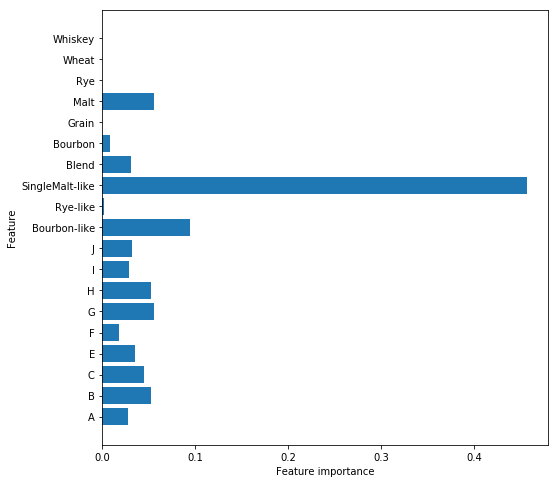

In [106]:
plot_feature_importances(xgb)

[[28  0 24 24 38 50]
 [ 0 51  2  1  1  1]
 [ 1  0  1  0  3  0]
 [ 1  0  3  4  1  1]
 [ 1  0  2  5  1  0]
 [ 1  0  4  8  7  5]]


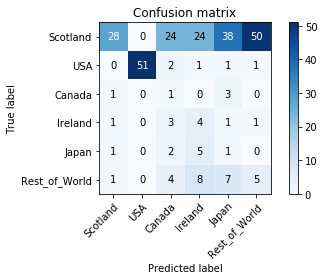

In [107]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, val_preds, classes=labels,
                      title='Confusion matrix')
plt.show()

In [110]:
param_grid = {
    "learning_rate": [.05],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [111]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(x_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(np.array(x_train_resampled))
val_preds = grid_clf.predict(np.array(x_test))
training_accuracy = accuracy_score(np.array(y_train_resampled), training_preds)
val_accuracy = accuracy_score(np.array(y_test), val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.05
max_depth: 6
min_child_weight: 10
n_estimators: 100
subsample: 0.7

Training Accuracy: 54.72%
Validation accuracy: 33.46%


In [112]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(x_train_resampled, y_train_resampled)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [114]:
clf.support_vectors_


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [115]:
clf.score(x_test,y_test)

0.36059479553903345

In [116]:
print(classification_report(y_test, x_test))

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [ ]:
labels = ['Scotland', 'USA', 'Canada', 'Ireland', 'Japan', 'Rest_of_World']

plot_confusion_matrix(y_test, x_test, classes=labels,
                      title='Confusion matrix')
plt.show()

In [119]:
from sklearn.dummy import DummyClassifier


dummy = DummyClassifier(strategy = 'uniform')
dummy.fit(x_train_resampled, y_train_resampled)

DummyClassifier(constant=None, random_state=None, strategy='uniform')

In [120]:
dummypred = dummy.predict(x_test)

In [121]:
print_metrics(y_test, dummypred)
  

Precision Score: 0.12639405204460966
Recall Score: 0.12639405204460966
Accuracy Score: 0.12639405204460966
F1 Score: 0.12639405204460966


In [1]:
pwd

'/Users/hamiltonchang/Documents/Coding/Section01/nyc-mhtn-ds-071519-lectures/Project_5'